# Systematic Asset Management Strategies : 

# Long only, Long-Short and Short only

## Import modules and data

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import copy
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

In [2]:
# All stocks of the CAC40
tickers = ["UG.PA","DG.PA","ML.PA","SAN.PA","RI.PA",
           "SW.PA","LR.PA","VIV.PA","FP.PA","AI.PA",
           "GLE.PA","OR.PA","CAP.PA","KER.PA","ATO.PA",
           "ORA.PA","BNP.PA","ENGI.PA","ACA.PA","AC.PA",
           "SGO.PA","MC.PA","HO.PA","SU.PA","WLN.PA",
           "AIR.PA","VIE.PA","BN.PA","EN.PA","CA.PA"]

In [3]:
# Creation of a dictionary and extraction of the prices for 10 years 
ohlcv_mon = {}            
start = dt.datetime.today()-dt.timedelta(3650)
end = dt.datetime.today()

# looping over tickers and creating a dataframe with close prices
for ticker in tickers:
    ohlcv_mon[ticker] = yf.download(ticker,start,end,interval='1mo')
    ohlcv_mon[ticker].dropna(inplace=True,how="all")

#Remove tickers without data
tickers = ohlcv_mon.keys()

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- UG.PA: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%**********

In [4]:
#Exemple for BNP Paribas
ohlcv_mon["BN.PA"]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-05-01,49.705002,50.980000,48.099998,50.950001,37.491852,48550093.0
2011-06-01,51.070000,52.939999,49.555000,51.450001,38.878777,44270362.0
2011-07-01,51.630001,53.160000,48.599998,49.799999,37.631935,38818195.0
2011-08-01,50.240002,50.889999,43.099998,47.000000,35.516090,73224603.0
2011-09-01,47.799999,48.575001,41.919998,46.200001,34.911560,57367412.0
...,...,...,...,...,...,...
2021-01-01,53.759998,56.540001,52.139999,54.959999,54.959999,39958311.0
2021-02-01,55.660000,58.680000,52.840000,56.459999,56.459999,39078786.0
2021-03-01,57.000000,61.500000,54.820000,58.500000,58.500000,40875651.0


In [5]:
#Compute daily return
ohlcv_dict = copy.deepcopy(ohlcv_mon)
return_df = pd.DataFrame()

for ticker in tickers:
    print("calculating monthly return for ",ticker)
    ohlcv_dict[ticker]["mon_ret"] = ohlcv_dict[ticker]["Adj Close"].pct_change()
    return_df[ticker] = ohlcv_dict[ticker]["mon_ret"]

calculating monthly return for  UG.PA
calculating monthly return for  DG.PA
calculating monthly return for  ML.PA
calculating monthly return for  SAN.PA
calculating monthly return for  RI.PA
calculating monthly return for  SW.PA
calculating monthly return for  LR.PA
calculating monthly return for  VIV.PA
calculating monthly return for  FP.PA
calculating monthly return for  AI.PA
calculating monthly return for  GLE.PA
calculating monthly return for  OR.PA
calculating monthly return for  CAP.PA
calculating monthly return for  KER.PA
calculating monthly return for  ATO.PA
calculating monthly return for  ORA.PA
calculating monthly return for  BNP.PA
calculating monthly return for  ENGI.PA
calculating monthly return for  ACA.PA
calculating monthly return for  AC.PA
calculating monthly return for  SGO.PA
calculating monthly return for  MC.PA
calculating monthly return for  HO.PA
calculating monthly return for  SU.PA
calculating monthly return for  WLN.PA
calculating monthly return for  AIR.P

## Long Only Strategy

In [6]:
# We will long the best m stocks of the previous month 
# and rebalance on a monthly basis by removing the worst x stocks of the portfolio

def pflio_long(DF,m,x):
    
    # Returns cumulative portfolio return
    # DF = dataframe with monthly return info for all stocks
    # m = number of stock in the portfolio
    # x = number of underperforming stocks to be removed from portfolio monthly"""
    
    df = DF.copy()
    portfolio = []
    monthly_ret_long = [0]
    for i in range(1,len(df)):
        if len(portfolio) > 0:
            monthly_ret_long.append(df[portfolio].iloc[i,:].mean())
            bad_stocks = df[portfolio].iloc[i,:].sort_values(ascending=True)[:x].index.values.tolist()
            portfolio = [t for t in portfolio if t not in bad_stocks]
        fill = m - len(portfolio)
        new_picks = df.iloc[i,:].sort_values(ascending=False)[:fill].index.values.tolist()
        # We avoid to have two time the same stock in the portfolio
        new_picks = [t for t in new_picks if t not in portfolio] 
        portfolio = portfolio + new_picks
    monthly_ret_df_long = pd.DataFrame(np.array(monthly_ret_long),columns=["mon_ret"])
    return monthly_ret_df_long

## Short Only Strategy 

In [7]:
# We will short the worst m stocks of the previous month 
# and rebalance on a monthly basis by removing the best x stocks of the portfolio

def pflio_short(DF,m,x):
    df = DF.copy()
    portfolio = []
    monthly_ret_short = [0]
    for i in range(1,len(df)):
        if len(portfolio) > 0:
            monthly_ret_short.append(df[portfolio].iloc[i,:].mean())
            bad_stocks = df[portfolio].iloc[i,:].sort_values(ascending=False)[:x].index.values.tolist()
            portfolio = [t for t in portfolio if t not in bad_stocks]
        fill = m - len(portfolio)
        new_picks = df.iloc[i,:].sort_values(ascending=True)[:fill].index.values.tolist()
        new_picks = [t for t in new_picks if t not in portfolio]
        portfolio = portfolio + new_picks
    monthly_ret_df_short = pd.DataFrame(np.array(monthly_ret_short),columns=["mon_ret"])
    monthly_ret_df_short = -monthly_ret_df_short
    return monthly_ret_df_short

## Long-Short Strategy

In [8]:
# It is the combination of the Long only and Short only strategies 
# Long 10 stocks and Short 5
def pflio_long_short(DF, m, x):
        long_short = pd.DataFrame()
        long_short = pflio_long(return_df, m, x) + 0.5* (pflio_short(return_df, m-5, x-1))
        return long_short

## Graphical representation

In [9]:
# We use the CAC40 as benchmark
cac40 = pd.DataFrame()
cac40 = yf.download("^FCHI",start,end,interval='1mo')
cac40["mon_ret"] = cac40["Adj Close"].pct_change()

[*********************100%***********************]  1 of 1 completed


In [10]:
# We need to create a list to use a xlabel
BNP = ohlcv_mon["BN.PA"]
BNP = BNP.reset_index()
date_list = BNP["Date"]

# xlabels are the date than we will plot
# incrementals are the "positions" of the dates
xlabels = []
incrementals = []
nb_date = len(date_list)
step = nb_date / 11

for i in np.arange(0, nb_date, step):
    # The previous format was "YY-mm-dd : HH-MM-SS"
    # We need to remove the hours and minutes
    xlabels.append(date_list[i].strftime('%Y-%m-%d'))
    incrementals.append(i)
    
print("xlabels = " + str(xlabels))
print("incrementals = " + str(incrementals))

xlabels = ['2011-05-01', '2012-04-01', '2013-03-01', '2014-02-01', '2015-01-01', '2015-12-01', '2016-11-01', '2017-10-01', '2018-09-01', '2019-08-01', '2020-07-01']
incrementals = [0.0, 11.0, 22.0, 33.0, 44.0, 55.0, 66.0, 77.0, 88.0, 99.0, 110.0]


In [11]:
# Choose number of stock to long or Short
m = 10
x = 3

No handles with labels found to put in legend.


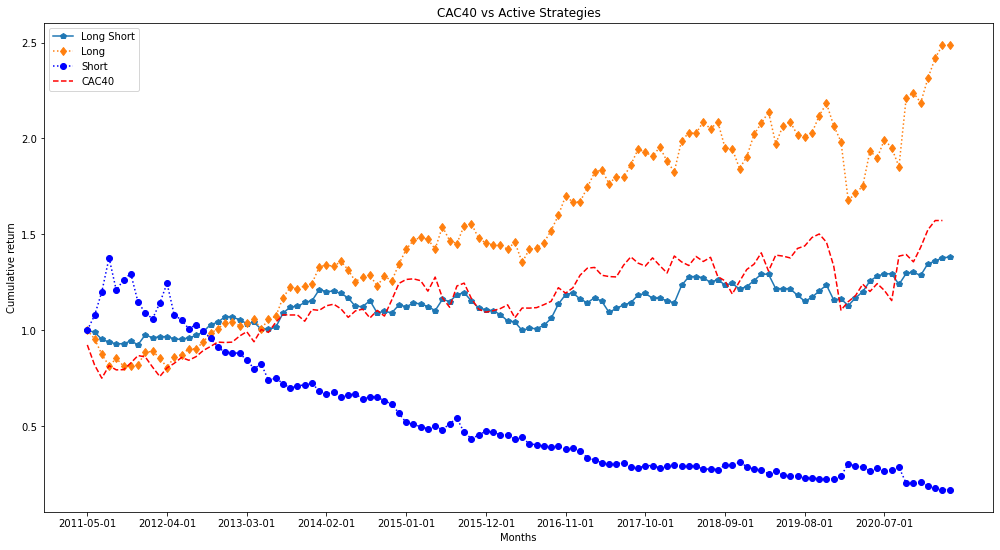

In [12]:
#Display the performance of the 3 strategies for 1 decade

fig, ax = plt.subplots(figsize=(17,9))

plt.legend()
#Set up the labels
plt.xticks(incrementals, xlabels)

#Long 10 stocks and Short 5
plt.plot((1+pflio_long_short(return_df,10,3)).cumprod().iloc[-150:],"p-", label="Long Short")
#Long 10 stocks
plt.plot((1+pflio_long(return_df,10,3)).cumprod().iloc[-150:],"d:", label="Long")
#Short 10 stocks
plt.plot((1+pflio_short(return_df,10,3)).cumprod().iloc[-150:],"b:o", label="Short")
#CAC40 as benchmark
plt.plot((1+cac40["mon_ret"][2:].reset_index(drop=True)).cumprod().iloc[-150:],"r--", label="CAC40")

plt.title("CAC40 vs Active Strategies")
plt.ylabel("Cumulative return")
plt.xlabel("Months")
ax.legend(["Long Short","Long","Short","CAC40"])


plt.legend()
plt.show()

In [13]:
# It is clear than the Long-Only strategy outperform the others strategies

## Annualised return, volatility and KPI

In [14]:
m = 10
x = 3
rf = 0.02 #risk-free rate, used for Sharpe ratio

### Compound Annual Growth Rate

In [15]:
def CAGR(DF):
    # function to calculate the Cumulative Annual Growth Rate of a strategy
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    n = len(df)/12
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

In [16]:
print ('CAGR of Long only strategy = ' + str(round(CAGR(pflio_long(return_df, m, x))*100, 2)) + '%' )
print ('CAGR of CAC40 = ' + str(round(CAGR(cac40)*100, 2)) + '%' )

CAGR of Long only strategy = 9.54%
CAGR of CAC40 = 4.52%


### Annualised Volatility

In [17]:
def volatility(DF):
    # function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["mon_ret"].std() * np.sqrt(12)
    return vol

In [18]:
print ('Vol of Long only strategy = ' + str(round(volatility(pflio_long(return_df, m, x))*100, 2)) + '%' )
print ('Vol of CAC40 = ' + str(round(volatility(cac40)*100, 2)) + '%' )

Vol of Long only strategy = 15.77%
Vol of CAC40 = 16.69%


### Annualised Sharpe Ratio

In [19]:
def sharpe(DF,rf):
    # function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr

In [20]:
print ('Sharpe ratio of Long only strategy = ' + str(round(sharpe(pflio_long(return_df, m, x), rf), 2))  )
print ('Sharpe ratio of CAC40 = ' + str(round(sharpe(cac40, rf), 2)) )

Sharpe ratio of Long only strategy = 0.48
Sharpe ratio of CAC40 = 0.15


### Max Drawdown over the period

In [21]:
def max_dd(DF):
    # function to calculate max drawdown
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [22]:
print ('Max Drawdown of Long only strategy = ' + str(round(max_dd(pflio_long(return_df, m, x))*100, 2)) + '%')
print ('Max Drawdown of CAC40 = ' + str(round(max_dd(cac40)*100, 2)) + '%')

Max Drawdown of Long only strategy = 23.18%
Max Drawdown of CAC40 = 26.46%


### Created by Pierre Marchand-Lentz and Emmanuel Zheng